# Interpretability Score

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import os

from flyvec import FlyVec

import gensim

import torch
from transformers import BertModel, BertTokenizer

In [2]:
def remove_trailing_newline(line):
    return line.split("\n")[0]

# available at https://github.com/avaapm/SEMCATdataset2018
path = "./SEMCATdataset2018/Categories"
categories = dict()
for category in os.listdir(path):
    cat = open(path + "/" + category, "r")
    categories[category.split("-")[0]] = list(map(remove_trailing_newline, cat.readlines()))
categories["car"]

['auto',
 'automobile',
 'buggy',
 'car',
 'compact',
 'convertible',
 'coupe',
 'cruiser',
 'hatchback',
 'hearse',
 'hybrid',
 'jeep',
 'limo',
 'limousine',
 'roadster',
 'rv',
 'sedan',
 'suv',
 'taxi',
 'van']

In [3]:
'''
Sorts the word embeddings in embedding_dict across a single dimension dim
'''

def get_sorted_dim_values(dim, embedding_dict, num_embeddings=20000):
    d = dict()
    for word in list(embedding_dict.keys())[:num_embeddings]:
        embedding = embedding_dict[word]
        d[word] = embedding[dim]
    return sorted(d.items(), key=lambda item: item[1])

In [4]:
'''
Implements the interpretability score metric for word embeddings
as described by Senel et al. in the paper
"Semantic structure and interpretability of word embeddings"
'''

def get_interpretability_score(dim_dict, k=5, num_dimensions=400):
    interpretability_score_sum = 0
    for i in range(num_dimensions):
        values = dim_dict[i]
        IS_i_js = []
        for j in categories.keys():
            S_j = set(categories[j])
            V_i_plus = set([w[0] for w in values[-(k * len(j)):]])
            V_i_minus = set([w[0] for w in values[:(k * len(j))]])
            IS_i_j_plus = len(S_j.intersection(V_i_plus)) / len(j) * 100
            IS_i_j_minus = len(S_j.intersection(V_i_minus)) / len(j) * 100
            IS_i_j = max(IS_i_j_plus, IS_i_j_minus)
            IS_i_js.append(IS_i_j)
        IS_i = np.max(np.array(IS_i_js))
        interpretability_score_sum += IS_i
    return interpretability_score_sum / num_dimensions

## FlyVec

In [5]:
flyvec_model = FlyVec.load()

In [6]:
flyvec_embedding_dict = dict()
for word in flyvec_model.token_vocab:
    if flyvec_model.tokenizer.tokenize(word) != []:
        flyvec_embedding_dict[word] = flyvec_model.get_dense_embedding(word)['embedding']

In [7]:
flyvec_dim_dict = dict()
for i in range(400):
    flyvec_dim_dict[i] = get_sorted_dim_values(i, flyvec_embedding_dict)

In [8]:
flyvec_interpretability_scores = []
for k in range(1,11):
    flyvec_interpretability_score = get_interpretability_score(flyvec_dim_dict, k)
    flyvec_interpretability_scores.append(flyvec_interpretability_score)
    print(k, flyvec_interpretability_score)

1 22.19663600288602
2 31.270770202020213
3 39.14275793650794
4 48.661904761904786
5 56.3942730880231
6 63.15962301587301
7 70.79434523809519
8 77.67847222222223
9 84.24722222222222
10 90.05813492063491


In [11]:
np.save("interpretability_scores/flyvec_interpretability_scores.npy", flyvec_interpretability_scores)

## GloVe

In [14]:
# https://nlp.stanford.edu/projects/glove/
# https://nlp.stanford.edu/data/glove.6B.zip
glove_50d = open("./models/glove.6B.50d.txt", "r", encoding="utf-8")
glove_100d = open("./models/glove.6B.100d.txt", "r", encoding="utf-8")
glove_200d = open("./models/glove.6B.200d.txt", "r", encoding="utf-8")
glove_300d = open("./models/glove.6B.300d.txt", "r", encoding="utf-8")

In [15]:
# adjusted from https://medium.com/analytics-vidhya/basics-of-using-pre-trained-glove-vectors-in-python-d38905f356db
def generate_glove_embedding_dict(glove):
    glove_embedding_dict = dict()
    for line in glove:
        tokens = line.split()
        word = tokens[0]
        vector = np.asarray(tokens[1:], "float32")
        glove_embedding_dict[word] = vector
    return glove_embedding_dict

In [16]:
glove_50d_embedding_dict = generate_glove_embedding_dict(glove_50d)
glove_100d_embedding_dict = generate_glove_embedding_dict(glove_100d)
glove_200d_embedding_dict = generate_glove_embedding_dict(glove_200d)
glove_300d_embedding_dict = generate_glove_embedding_dict(glove_300d)

In [ ]:
glove_50d_dim_dict = {dim: get_sorted_dim_values(dim, glove_50d_embedding_dict) for dim in range(50)}
glove_100d_dim_dict = {dim: get_sorted_dim_values(dim, glove_100d_embedding_dict) for dim in range(100)}
glove_200d_dim_dict = {dim: get_sorted_dim_values(dim, glove_200d_embedding_dict) for dim in range(200)}
glove_300d_dim_dict = {dim: get_sorted_dim_values(dim, glove_300d_embedding_dict) for dim in range(300)}

In [18]:
def calculate_glove_interpretabiliy_scores(embedding_dict, dim):
    glove_interpretability_scores = []
    for k in range(1,11):
        glove_interpretability_score = get_interpretability_score(embedding_dict, k, num_dimensions=dim)
        glove_interpretability_scores.append(glove_interpretability_score)
        print(k, glove_interpretability_score)
    return glove_interpretability_scores

In [19]:
glove_50d_interpretability_scores = calculate_glove_interpretabiliy_scores(glove_50d_dim_dict, 50)

1 19.46796157059315
2 29.91825396825397
3 38.159523809523805
4 45.86449456975772
5 52.06190476190476
6 62.843650793650795
7 70.06390977443608
8 75.2936507936508
9 82.17063492063491
10 88.05396825396825


In [20]:
glove_100d_interpretability_scores = calculate_glove_interpretabiliy_scores(glove_100d_dim_dict, 100)

1 17.888131313131318
2 28.979473304473295
3 38.0326479076479
4 46.04761904761907
5 53.092857142857135
6 62.273015873015865
7 69.38531746031745
8 76.32261904761907
9 83.96666666666668
10 89.43650793650795


In [21]:
glove_200d_interpretability_scores = calculate_glove_interpretabiliy_scores(glove_200d_dim_dict, 200)

1 18.99065641960378
2 27.92441710336448
3 35.20967950178475
4 40.80789378749905
5 46.353925533530784
6 52.24043347003873
7 57.702662907268184
8 63.384722222222216
9 69.68273809523808
10 75.66567460317458


In [22]:
glove_300d_interpretability_scores = calculate_glove_interpretabiliy_scores(glove_300d_dim_dict, 300)

1 18.6966601137654
2 26.840752765752782
3 34.23352573352575
4 39.81216931216938
5 44.77804232804241
6 50.203042328042415
7 54.837566137566206
8 60.97385762385763
9 65.20429292929296
10 69.44073757626388


In [24]:
np.save("interpretability_scores/glove_50d_interpretability_scores.npy", glove_50d_interpretability_scores)
np.save("interpretability_scores/glove_100d_interpretability_scores.npy", glove_100d_interpretability_scores)
np.save("interpretability_scores/glove_200d_interpretability_scores.npy", glove_200d_interpretability_scores)
np.save("interpretability_scores/glove_300d_interpretability_scores.npy", glove_300d_interpretability_scores)

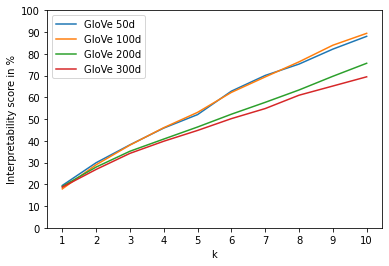

In [25]:
domain = list(range(1,11))
plt.plot(domain, glove_50d_interpretability_scores)
plt.plot(domain, glove_100d_interpretability_scores)
plt.plot(domain, glove_200d_interpretability_scores)
plt.plot(domain, glove_300d_interpretability_scores)
plt.xticks(domain)
plt.yticks(list(range(0,101,10)))
plt.xlabel("k")
plt.ylabel("Interpretability score in %")
plt.legend(["GloVe 50d","GloVe 100d","GloVe 200d","GloVe 300d"])
plt.show()

## BERT

In [ ]:
bert_tiny = "google/bert_uncased_L-2_H-128_A-2"
bert_tiny_tokenizer = BertTokenizer.from_pretrained(bert_tiny)
bert_tiny_model = BertModel.from_pretrained(bert_tiny)

In [ ]:
bert_mini = "google/bert_uncased_L-4_H-256_A-4"
bert_mini_tokenizer = BertTokenizer.from_pretrained(bert_mini)
bert_mini_model = BertModel.from_pretrained(bert_mini)

In [ ]:
bert_small = "google/bert_uncased_L-4_H-512_A-8"
bert_small_tokenizer = BertTokenizer.from_pretrained(bert_small)
bert_small_model = BertModel.from_pretrained(bert_small)

In [ ]:
bert_medium = "google/bert_uncased_L-8_H-512_A-8"
bert_medium_tokenizer = BertTokenizer.from_pretrained(bert_medium)
bert_medium_model = BertModel.from_pretrained(bert_medium)

In [ ]:
bert_base = "bert-base-uncased"
bert_base_tokenizer = BertTokenizer.from_pretrained(bert_base)
bert_base_model = BertModel.from_pretrained(bert_base)

In [11]:
# based on http://stackoverflow.com/questions/63126386/ddg#63128700
bert_tiny_embedding_dict = {token: bert_tiny_model.get_input_embeddings()(torch.tensor(id))  for token, id in bert_tiny_tokenizer.get_vocab().items()}
bert_mini_embedding_dict = {token: bert_mini_model.get_input_embeddings()(torch.tensor(id))  for token, id in bert_mini_tokenizer.get_vocab().items()}
bert_small_embedding_dict = {token: bert_small_model.get_input_embeddings()(torch.tensor(id))  for token, id in bert_small_tokenizer.get_vocab().items()}
bert_medium_embedding_dict = {token: bert_medium_model.get_input_embeddings()(torch.tensor(id))  for token, id in bert_medium_tokenizer.get_vocab().items()}
bert_base_embedding_dict = {token: bert_base_model.get_input_embeddings()(torch.tensor(id))  for token, id in bert_base_tokenizer.get_vocab().items()}

In [ ]:
bert_tiny_dim_dict = {dim: get_sorted_dim_values(dim, bert_tiny_embedding_dict) for dim in range(128)}
bert_mini_dim_dict = {dim: get_sorted_dim_values(dim, bert_mini_embedding_dict) for dim in range(256)}
bert_small_dim_dict = {dim: get_sorted_dim_values(dim, bert_small_embedding_dict) for dim in range(512)}
bert_medium_dim_dict = {dim: get_sorted_dim_values(dim, bert_medium_embedding_dict) for dim in range(512)}
bert_base_dim_dict = {dim: get_sorted_dim_values(dim, bert_base_embedding_dict) for dim in range(756)}

In [13]:
def calculate_bert_interpretabiliy_scores(dim_dict, dim):
    bert_interpretability_scores = []
    for k in range(1,11):
        bert_interpretability_score = get_interpretability_score(dim_dict, k, num_dimensions=dim)
        bert_interpretability_scores.append(bert_interpretability_score)
        print(k, bert_interpretability_score)
    return bert_interpretability_scores

In [43]:
bert_tiny_interpretability_scores = calculate_bert_interpretabiliy_scores(bert_tiny_dim_dict, 128)
np.save("interpretability_scores/bert_tiny_interpretability_scores.npy", bert_tiny_interpretability_scores)

1 13.21484790337586
2 20.271070075757578
3 25.22842825577201
4 30.44417388167389
5 33.749041756854254
6 37.60543492965368
7 42.32712166305916
8 45.06273674242422
9 49.765900902825244
10 53.481516884066224


In [14]:
bert_mini_interpretability_scores = calculate_bert_interpretabiliy_scores(bert_mini_dim_dict, 256)
np.save("interpretability_scores/bert_mini_interpretability_scores.npy", bert_mini_interpretability_scores)

1 16.74059156532429
2 22.37847222222224
3 28.644325509559884
4 33.03695436507937
5 38.009362599206334
6 41.986607142857146
7 45.236474679834075
8 48.74973225559169
9 53.17894345238096
10 56.022854099026006


In [ ]:
bert_small_interpretability_scores = calculate_bert_interpretabiliy_scores(bert_small_dim_dict, 512)

In [ ]:
bert_medium_interpretability_scores = calculate_bert_interpretabiliy_scores(bert_medium_dim_dict, 512)

In [ ]:
bert_base_interpretability_scores = calculate_bert_interpretabiliy_scores(bert_base_dim_dict, 756)

## word2vec

In [8]:
# https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz

word2vec_model = gensim.models.KeyedVectors.load_word2vec_format('models/GoogleNews-vectors-negative300.bin', binary=True) 

In [9]:
word2vec_embedding_dict = dict()
for k in list(word2vec_model.key_to_index.keys())[:20000]:
    word2vec_embedding_dict[k] = word2vec_model[k]

In [12]:
word2vec_embedding_dict = dict()
for k in flyvec_model.vocab:
    word2vec_embedding_dict[k] = word2vec_model[k]

In [13]:
dim_dict = dict()
for i in range(300):
    dim_dict[i] = get_sorted_dim_values(i, word2vec_embedding_dict)

In [ ]:
word2vec_interpretability_scores = []
for k in range(1,11):
    word2vec_interpretability_score = get_interpretability_score(dim_dict, k, num_dimensions=300)
    word2vec_interpretability_scores.append(word2vec_interpretability_score)
    print(k, word2vec_interpretability_score)

In [32]:
np.save("interpretability_scores/word2vec_interpretability_scores.npy", word2vec_interpretability_scores)

## Random Embeddings (Baseline)

In [ ]:
random_embedding_dict = {token: np.random.random(400) for token in flyvec_model.token_vocab}
random_dim_dict = {dim: get_sorted_dim_values(dim, random_embedding_dict) for dim in range(300)}

In [40]:
random_interpretability_scores = []
for k in range(1,11):
    random_interpretability_score = get_interpretability_score(random_dim_dict, k, num_dimensions=300)
    random_interpretability_scores.append(random_interpretability_score)
    print(k, random_interpretability_score)

1 19.27157287157289
2 23.621849446849456
3 27.295502645502633
4 30.365909090909074
5 32.640379990380005
6 35.18892496392501
7 37.375974025974095
8 38.62518037518043
9 40.2876623376624
10 42.04758297258304


## Comparison

In [34]:
flyvec_interpretability_scores = np.load("interpretability_scores/flyvec_interpretability_scores.npy")

In [35]:
word2vec_interpretability_scores = np.load("interpretability_scores/word2vec_interpretability_scores.npy")

In [36]:
glove_50d_interpretability_scores = np.load("interpretability_scores/glove_50d_interpretability_scores.npy")
#glove_100d_interpretability_scores = np.load("interpretability_scores/glove_100d_interpretability_scores.npy")
#glove_200d_interpretability_scores = np.load("interpretability_scores/glove_200d_interpretability_scores.npy")
glove_300d_interpretability_scores = np.load("interpretability_scores/glove_300d_interpretability_scores.npy")

In [37]:
bert_tiny_interpretability_scores = np.load("interpretability_scores/bert_tiny_interpretability_scores.npy")
bert_mini_interpretability_scores = np.load("interpretability_scores/bert_mini_interpretability_scores.npy")

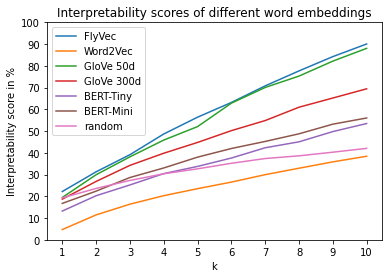

In [41]:
domain = list(range(1,11))
plt.plot(domain, flyvec_interpretability_scores)
plt.plot(domain, word2vec_interpretability_scores)
plt.plot(domain, glove_50d_interpretability_scores)
#plt.plot(domain, glove_100d_interpretability_scores)
#plt.plot(domain, glove_200d_interpretability_scores)
plt.plot(domain, glove_300d_interpretability_scores)
plt.plot(domain, bert_tiny_interpretability_scores)
plt.plot(domain, bert_mini_interpretability_scores)
plt.plot(domain, random_interpretability_scores)
plt.xticks(domain)
plt.yticks(list(range(0,101,10)))
plt.xlabel("k")
plt.ylabel("Interpretability score in %")
plt.legend(["FlyVec","Word2Vec","GloVe 50d","GloVe 300d", "BERT-Tiny", "BERT-Mini", "random"])
plt.title("Interpretability scores of different word embeddings")
#plt.savefig("figure.png", dpi=300)
plt.show()